In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.model_selection import cross_val_score,learning_curve
from sklearn.metrics import mean_absolute_error as MAE,root_mean_squared_error as RMSE,r2_score as R2,make_scorer

pd.set_option('display.max_rows',300)
pd.set_option('display.max_column',20)


#### 1.Dataset import

In [2]:
np.random.seed(42)
#X_train import and split to X_train and X_val(named as X_features)
X_features = pd.read_csv("data/X_features.csv")
y_target = pd.read_csv("data/y_target.csv")
print("X_features shape:",X_features.shape)
print("y_target shape:",y_target.shape)

#import independent dataset
X_independent_test = pd.read_csv("data/X_independent_test.csv")
y_independent_test = pd.read_csv("data/y_independent_test.csv")
print("X_independent_test shape:",X_independent_test.shape)
print("y_independent_test shape:",y_independent_test.shape)

#X_features_copy combined with X_features
X_features_copy = X_features.copy()
X_combined = pd.concat([X_features,X_features_copy],ignore_index=True)

#add guassian noise to y_target
noise = np.random.normal(0,0.2,y_target.shape)#average value eaqual to 0;
y_target_with_noise = y_target + noise
y_combined = pd.concat([y_target,y_target_with_noise])


#X minmax scaler for X_combined and X_independent_test
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler()
X_combined_norm = X_scaler.fit_transform(X_combined)
X_independent_test_norm = X_scaler.fit_transform(X_independent_test)





X_features shape: (110, 12)
y_target shape: (110, 1)
X_independent_test shape: (13, 12)
y_independent_test shape: (13, 1)


In [3]:
#X_combined_norm res
X_combined_norm = pd.DataFrame(X_combined_norm,columns=X_combined.columns)
X_combined_norm.head()

,A_site,Conc(mg/ml),H_Acceptors,H_Donors,Rot_bonds,Mol_Wt,TPSA,AvgIpc,Hydrogen,Oxide,Nitrogen,Halide
0,0.0,0.259175,0.000000,0.00,0.153846,0.190302,0.000000,0.664815,0.250000,0.000000,0.166667,0.2
1,0.0,0.013384,0.111111,0.00,0.192308,0.201861,0.051144,0.752115,0.267857,0.000000,0.333333,0.8
2,0.0,0.028786,0.111111,0.00,0.076923,0.172869,0.099094,0.723895,0.178571,0.111111,0.000000,0.0
3,0.0,0.031359,0.222222,0.25,0.115385,0.192718,0.216533,0.742535,0.196429,0.222222,0.000000,0.0
4,1.0,0.096356,0.444444,0.00,0.192308,0.274529,0.383200,0.777060,0.267857,0.333333,0.333333,0.6


In [4]:
#y_res
y_combined.head()

,EQE enhanced ratio
0,2.7368
1,1.6098
2,1.1568
3,1.1811
4,1.9079


In [5]:
X_independent_test_norm = pd.DataFrame(X_independent_test_norm,columns=X_independent_test.columns)
X_independent_test_norm.head()

,A_site,Conc(mg/ml),H_Acceptors,H_Donors,Rot_bonds,Mol_Wt,TPSA,AvgIpc,Hydrogen,Oxide,Nitrogen,Halide
0,1.0,0.000000,0.500000,1.000000,0.071429,0.025851,0.969849,0.663011,0.095238,0.333333,0.666667,0.0
1,1.0,0.095114,0.500000,0.666667,0.357143,0.036818,0.704495,0.788467,0.261905,0.333333,0.333333,0.0
2,0.0,0.396742,0.000000,0.000000,0.357143,0.120105,0.000000,0.836026,0.380952,0.000000,0.333333,0.2
3,0.0,0.225814,0.166667,0.333333,0.214286,0.200849,0.289497,0.923200,0.333333,0.000000,0.333333,0.2
4,0.0,0.497285,0.000000,0.000000,0.285714,0.157069,0.000000,0.824010,0.333333,0.000000,0.333333,0.2


In [6]:
X_combined_norm.shape,y_combined.shape

((220, 12), (220, 1))

In [7]:
np.random.seed(42)
#Splitting training and test sets
n_bins = 5
y_bins = pd.qcut(y_combined.values.ravel(), n_bins, labels=False)
X_train, X_val, y_train, y_val = train_test_split(X_combined_norm, y_combined.values.ravel(), test_size= 0.2,stratify = y_bins,random_state = 42)


#### 2.Function defination

In [8]:
#model trainning and evaluation function


def parity_plot(y_train_pred, y_val_pred,y_independent_test_pred,y_1 = y_train, y_2 = y_val,y_3 = y_independent_test,model_name_s =''):
  
    #Figuresize
    plt.figure(figsize=(6,6))
 
    #Training set
    plt.scatter(y_1, y_train_pred, c ='#AFAFAF', label='Training set', marker="o",s = 120,zorder = 2,alpha = 0.8,edgecolors='w')#s=40
    
    #Validation set
    plt.scatter(y_2, y_val_pred, c ='#E89494', label='Validation set', marker="o",zorder = 2,s=120,alpha = 0.8,edgecolors='w')
    
    #Independent test set
    plt.scatter(y_3, y_independent_test_pred, c ='#56698F', label='Inde_test set', marker="o",s=120,zorder = 2,alpha=0.8,edgecolors='w')
    
    #Background grids
    plt.grid(True, color='#eaeaea')
    
    #reference line
    plt.plot([-1,7], [-1, 7], '--', lw = 2,label = 'reference', c ='#eaeaea',alpha=0.8,zorder = 1)
    
    plt.title(f'Performance of {model_name_s}',fontsize = 20,fontstyle ='italic',loc = 'center')
    plt.xlim(-1, 7)
    plt.ylim(-1, 7)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.xlabel('Observations',fontsize = 20)
    plt.ylabel('Predictions',fontsize = 20)
    plt.legend(loc="upper left",fontsize = 18)
    
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    
    plt.savefig(f"output_figures/performance_{model_name_s}.png",dpi = 600)
    return plt.show()

def evaluator(y_train_pred,y_val_pred,y_independent_test_pred):
    #Training set
    rmse_train = RMSE(y_train,y_train_pred)
    mse_train = rmse_train ** 2
    mae_train = MAE(y_train, y_train_pred)
    r2_train = R2(y_train,y_train_pred)
    
    #Validation set
    rmse_val = RMSE(y_val, y_val_pred)
    mse_val = rmse_val ** 2
    mae_val = MAE(y_val, y_val_pred)
    r2_val = R2(y_val,y_val_pred)
    
    #Independent test set
    rmse_test = RMSE(y_independent_test, y_independent_test_pred)
    mse_test = rmse_test ** 2
    
    mae_test = MAE(y_independent_test, y_independent_test_pred)
    r2_test = R2(y_independent_test,y_independent_test_pred)
    

    eval_res = pd.DataFrame({
        "Evaluation criterion":["MSE","RMSE","MAE","R2_Score"],
        "Training Data": [mse_train,rmse_train,mae_train,r2_train],
        "validtation Data": [mse_val,rmse_val,mae_val,r2_val],
        'independent test Data':[mse_test,rmse_test,mae_test,r2_test]
    })
    
    return eval_res

def model_builder(model_name):
    #trainning model
    model_name.fit(X_train, y_train)
    
    y_train_pred = model_name.predict(X_train)
    
    y_val_pred = model_name.predict(X_val)
    
    y_independent_test_pred = []
    y_independent_test_pred = model_name.predict(X_independent_test_norm)
    
    model_name_s = type(model_name).__name__
    
    parity_plot(y_train_pred,y_val_pred,y_independent_test_pred,model_name_s = model_name_s)
    
    eval_res = evaluator(y_train_pred,y_val_pred,y_independent_test_pred)
    
    return eval_res,y_val_pred

 #Model cross validation
def cv_score_calculor(model_name,fold = 5):
   
    X = X_train
    y = y_train
    score_ave_negMSE_train = cross_val_score(model_name,X,y,cv=fold,scoring='neg_mean_squared_error',n_jobs = -1).mean()
    score_ave_negRMSE_train = cross_val_score(model_name,X,y,cv = fold,scoring='neg_root_mean_squared_error',n_jobs = -1).mean()
    score_ave_negMAE_train = cross_val_score(model_name,X,y,cv = fold,scoring='neg_mean_absolute_error',n_jobs = -1).mean()
    score_ave_default_train = cross_val_score(model_name,X,y,cv = fold,scoring=None,n_jobs = -1).mean()
    
    cv_res = pd.DataFrame({
        "Score type":["trainset_neg_MSE","trainset_neg_RMSE","train_neg_MAE","train_defalut_score"],
        "CV score on average": [score_ave_negMSE_train,score_ave_negRMSE_train,score_ave_negMAE_train, score_ave_default_train],
    })
    
    return cv_res


def learning_curve_plot(model_name,fold = 5,y_lim = 1,model_name_s =''):
    train_sizes, train_scores, test_scores = learning_curve (
        model_name, X_combined_norm, y_combined, cv = fold,
        scoring = make_scorer(MAE, greater_is_better=False),
        train_sizes=np.linspace(0.1, 1.0, 20), n_jobs=-1)

    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = -np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = -np.std(test_scores, axis = 1)


    plt.figure(figsize=(6,6))
  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, 
                            alpha=0.1, color="#AFAFAF")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, 
                            alpha=0.1, color="#E89494")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="#AFAFAF", label=r"score of training set",alpha = 0.8,markersize = 8)
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#E89494", label=r"score of validation set",alpha = 0.8,markersize = 8)

    plt.ylim(0,y_lim)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.xlabel('Sample count',fontsize = 20)
    plt.ylabel('MSE',fontsize = 20)
    plt.title(f'Learning curve of {model_name_s}',fontsize = 20,fontstyle ='italic',loc = 'center')
    plt.legend(loc = "upper right",fontsize = 18)
    
    plt.savefig(f"output_figures/LC_{model_name_s}.png",dpi = 600)
   
    return  plt.show() 
   
   

#### 3.Model trainning 

##### 3.1 linear reg

In [9]:
#Simple linearReg without gridsearch (simple LR reg)
from sklearn.linear_model import  LinearRegression
lr_reg = LinearRegression()
#5-fold cross validation
cv_score_calculor(lr_reg)

,Score type,CV score on average
0,trainset_neg_MSE,-0.688005
1,trainset_neg_RMSE,-0.822486
2,train_neg_MAE,-0.645964
3,train_defalut_score,0.061957


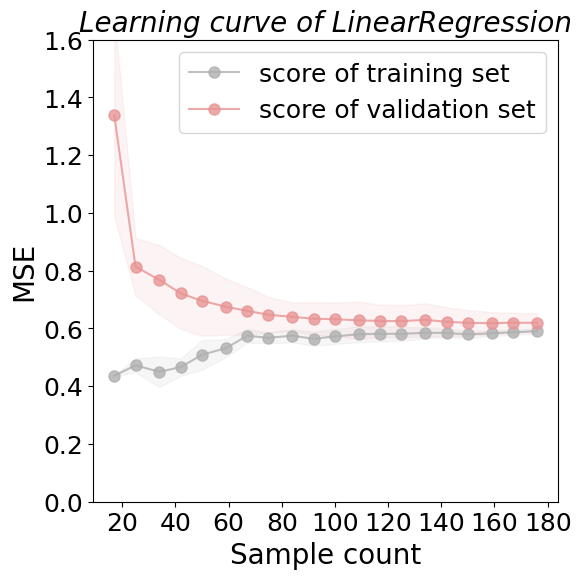

In [10]:
#Plot learning curve
lc_lr = learning_curve_plot(lr_reg,y_lim=1.6,model_name_s= type(lr_reg).__name__)
lc_lr

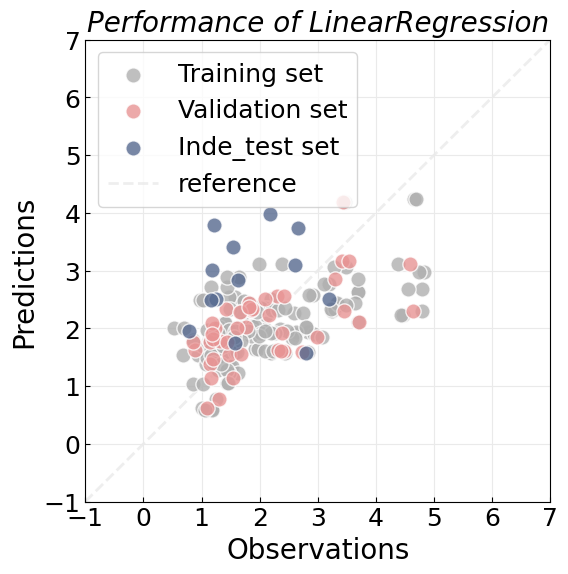

,Evaluation criterion,Training Data,validtation Data,independent test Data
0,MSE,0.570254,0.584853,2.020542
1,RMSE,0.755152,0.764757,1.421458
2,MAE,0.589186,0.625144,1.283373
3,R2_Score,0.394533,0.375116,-2.721596


In [11]:
#Model fit and independent test prediction
lr_metrics,y_val_pred = model_builder(lr_reg)
lr_metrics

In [12]:
validation_mse_list = []
validation_rmse_list = []
validation_mae_list =[]
for i in range(20):
    
    X_train_n, X_validation_n, y_train_n, y_validation_n = train_test_split(X_combined_norm, y_combined.values.ravel(), test_size=0.2)
    lr_reg.fit(X_train_n,y_train_n)
    
    y_validation_pred_n = lr_reg.predict(X_validation_n)
    validation_rmse = RMSE(y_validation_pred_n,y_validation_n)
    validation_mse = validation_rmse ** 2
    validation_mae = MAE(y_validation_pred_n,y_validation_n)
    
    validation_mse_list.append(validation_mse)
    validation_rmse_list.append(validation_rmse)
    validation_mae_list.append(validation_mae)


print("Average validation_mse after 20 interations:",sum(validation_mse_list)/len(validation_mse_list))
print("Average validation_rmse after 20 interations:",sum(validation_rmse_list)/len(validation_rmse_list))
print("Average validation_mae after 20 interations:",sum(validation_mae_list)/len(validation_mae_list))

Average validation_mse after 20 interations: 0.6072287497554765
Average validation_rmse after 20 interations: 0.7761953882047175
Average validation_mae after 20 interations: 0.6155233815918417


##### 3.2 RF reg

In [13]:
from sklearn.ensemble import RandomForestRegressor
#Grid search of tuning hyperparameters
rf_reg = RandomForestRegressor(random_state = 42)
param_grid = {
          'n_estimators': [40,60,80],
          'max_depth': [None,5,10],
          'min_samples_split': [2, 4],
          'min_samples_leaf': [1, 2]
}
# Define the search object
search = GridSearchCV(rf_reg, param_grid, cv = 5,n_jobs = -1,error_score = 'raise',verbose=1)

# Fit the search object to the training set
search.fit(X_train, y_train)

#Show best parameters
print(f'rf_reg best parameters: {search.best_params_}')

best_rf = search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits
rf_reg best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80}


In [14]:
#Cross_validation scores in training set
cv_score_calculor(best_rf)


,Score type,CV score on average
0,trainset_neg_MSE,-0.387619
1,trainset_neg_RMSE,-0.613269
2,train_neg_MAE,-0.447192
3,train_defalut_score,0.472624


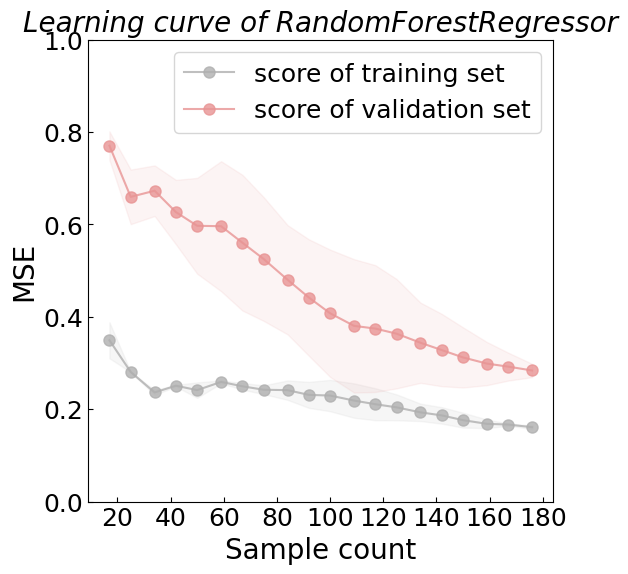

In [15]:
#Plot learning curve in entire dataset 
lc_rf = learning_curve_plot(best_rf,model_name_s= type(best_rf).__name__)
lc_rf

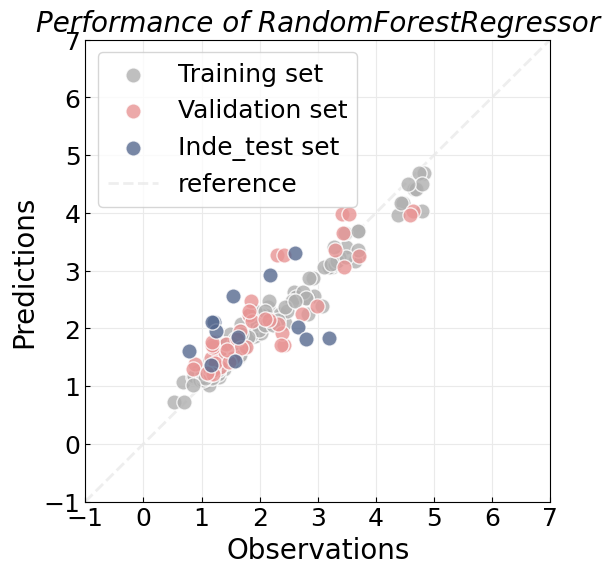

,Evaluation criterion,Training Data,validtation Data,independent test Data
0,MSE,0.039644,0.178780,0.633559
1,RMSE,0.199109,0.422824,0.795964
2,MAE,0.146913,0.345421,0.719165
3,R2_Score,0.957908,0.808983,-0.166940


In [16]:
#Model fit and show the results
best_rf_metrics,y_test_pred = model_builder(best_rf)
best_rf_metrics

In [17]:
validation_mse_list = []
validation_rmse_list = []
validation_mae_list =[]
for i in range(20):
    
    X_train_n, X_validation_n, y_train_n, y_validation_n = train_test_split(X_combined_norm, y_combined.values.ravel(), test_size=0.2)
    best_rf.fit(X_train_n,y_train_n)
    
    y_validation_pred_n = best_rf.predict(X_validation_n)
    validation_rmse = RMSE(y_validation_pred_n,y_validation_n)
    validation_mse = validation_rmse ** 2
    validation_mae = MAE(y_validation_pred_n,y_validation_n)
    
    validation_mse_list.append(validation_mse)
    validation_rmse_list.append(validation_rmse)
    validation_mae_list.append(validation_mae)


print("Average validation_mse after 20 interations:",sum(validation_mse_list)/len(validation_mse_list))
print("Average validation_rmse after 20 interations:",sum(validation_rmse_list)/len(validation_rmse_list))
print("Average validation_mae after 20 interations:",sum(validation_mae_list)/len(validation_mae_list))

Average validation_mse after 20 interations: 0.2922087069273897
Average validation_rmse after 20 interations: 0.5285821315009019
Average validation_mae after 20 interations: 0.3770312984191465


##### 3.3 SVR

In [18]:

from sklearn.svm import SVR
svm_reg = SVR()
param_grid = {
    'C': [5,10,15,20],
    'epsilon': [0.03,0.06,0.1,0.15,0.2],  
}

search = GridSearchCV(svm_reg, param_grid, cv = 5,n_jobs = -1,error_score = 'raise',verbose=1)

search.fit(X_train, y_train)

print(f'svm_reg best parameters: {search.best_params_}')

best_svr = search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits
svm_reg best parameters: {'C': 15, 'epsilon': 0.2}


In [19]:
cv_score_calculor(best_svr)

,Score type,CV score on average
0,trainset_neg_MSE,-0.436884
1,trainset_neg_RMSE,-0.655488
2,train_neg_MAE,-0.467916
3,train_defalut_score,0.403786


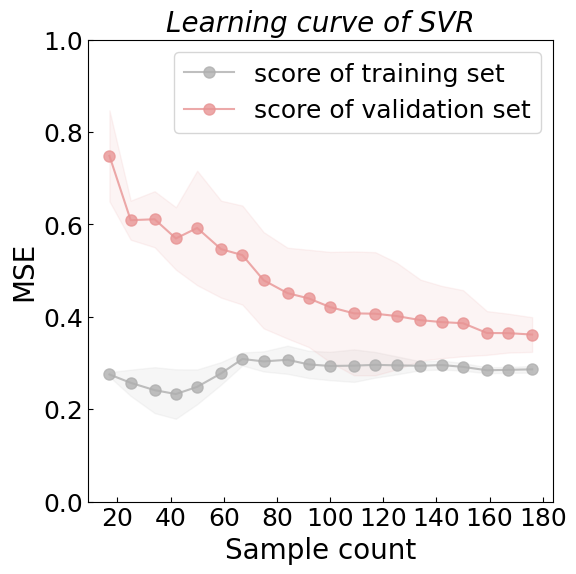

In [20]:
lc_svr = learning_curve_plot(best_svr,model_name_s= type(best_svr).__name__)
lc_svr

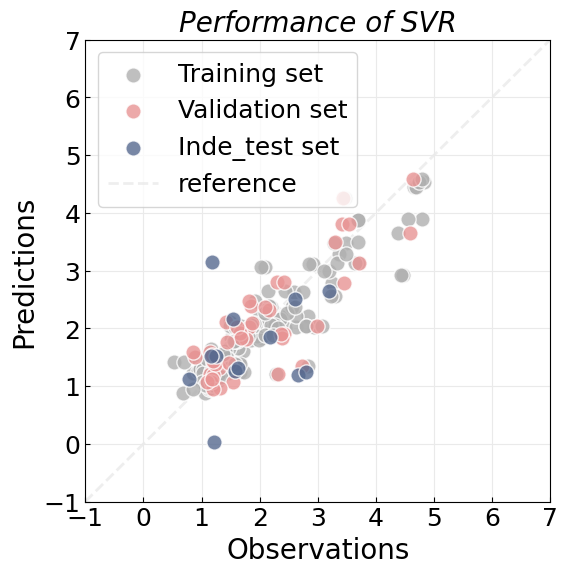

,Evaluation criterion,Training Data,validtation Data,independent test Data
0,MSE,0.153784,0.258810,0.858589
1,RMSE,0.392153,0.508734,0.926601
2,MAE,0.280654,0.402804,0.721625
3,R2_Score,0.836720,0.723475,-0.581419


In [21]:
best_svr_metrics,y_test_pred = model_builder(best_svr)
best_svr_metrics

In [22]:
validation_mse_list = []
validation_rmse_list = []
validation_mae_list =[]
for i in range(20):
    
    X_train_n, X_validation_n, y_train_n, y_validation_n = train_test_split(X_combined_norm, y_combined.values.ravel(), test_size=0.2)
    best_svr.fit(X_train_n,y_train_n)
    
    y_validation_pred_n = best_svr.predict(X_validation_n)
    validation_rmse = RMSE(y_validation_pred_n,y_validation_n)
    validation_mse = validation_rmse ** 2
    validation_mae = MAE(y_validation_pred_n,y_validation_n)
    
    validation_mse_list.append(validation_mse)
    validation_rmse_list.append(validation_rmse)
    validation_mae_list.append(validation_mae)


print("Average validation_mse after 20 interations:",sum(validation_mse_list)/len(validation_mse_list))
print("Average validation_rmse after 20 interations:",sum(validation_rmse_list)/len(validation_rmse_list))
print("Average validation_mae after 20 interations:",sum(validation_mae_list)/len(validation_mae_list))

Average validation_mse after 20 interations: 0.3092700733932847
Average validation_rmse after 20 interations: 0.5504106406540281
Average validation_mae after 20 interations: 0.3943593038894432


##### 3.4 xgb

In [23]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor(subsample = 0.8,objective='reg:squarederror',random_state = 42)

param_grid = {
    'min_child_weight' : [2,3,4],
    'n_estimators': [110,115,120,125,130], 
    'max_depth': [5,10,15],     
}

search = GridSearchCV(xgb_reg, param_grid, cv = 5,n_jobs = -1,error_score = 'raise',verbose=1)

search.fit(X_train, y_train)

print(f'xgb best parameters: {search.best_params_}')

best_xgbr = search.best_estimator_


Fitting 5 folds for each of 45 candidates, totalling 225 fits
xgb best parameters: {'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 125}


In [24]:
cv_score_calculor(best_xgbr)

,Score type,CV score on average
0,trainset_neg_MSE,-0.347504
1,trainset_neg_RMSE,-0.573424
2,train_neg_MAE,-0.367280
3,train_defalut_score,0.574227


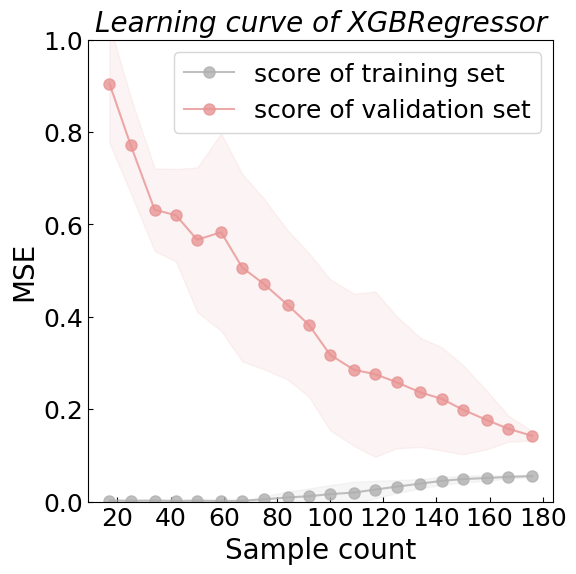

In [25]:
lc_xgbr = learning_curve_plot(best_xgbr,model_name_s= type(best_xgbr).__name__)
lc_xgbr 

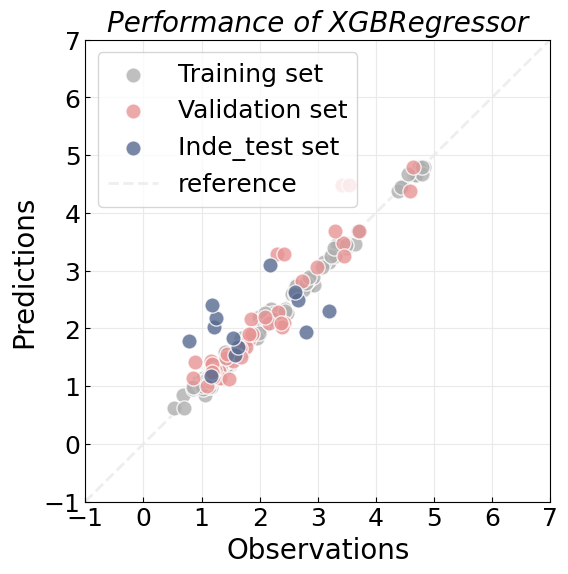

,Evaluation criterion,Training Data,validtation Data,independent test Data
0,MSE,0.006580,0.118920,0.499339
1,RMSE,0.081120,0.344848,0.706639
2,MAE,0.060362,0.216977,0.554016
3,R2_Score,0.993013,0.872940,0.080278


In [26]:
best_xgbr_metrics,y_test_pred = model_builder(best_xgbr)
best_xgbr_metrics

In [27]:
validation_mse_list = []
validation_rmse_list = []
validation_mae_list =[]
for i in range(20):
    
    X_train_n, X_validation_n, y_train_n, y_validation_n = train_test_split(X_combined_norm, y_combined.values.ravel(), test_size=0.2)
    best_xgbr.fit(X_train_n,y_train_n)
    
    y_validation_pred_n = best_xgbr.predict(X_validation_n)
    validation_rmse = RMSE(y_validation_pred_n,y_validation_n)
    validation_mse = validation_rmse ** 2
    validation_mae = MAE(y_validation_pred_n,y_validation_n)
    
    validation_mse_list.append(validation_mse)
    validation_rmse_list.append(validation_rmse)
    validation_mae_list.append(validation_mae)


print("Average validation_mse after 20 interations:",sum(validation_mse_list)/len(validation_mse_list))
print("Average validation_rmse after 20 interations:",sum(validation_rmse_list)/len(validation_rmse_list))
print("Average validation_mae after 20 interations:",sum(validation_mae_list)/len(validation_mae_list))

Average validation_mse after 20 interations: 0.19235775401401065
Average validation_rmse after 20 interations: 0.41781914767101574
Average validation_mae after 20 interations: 0.25638453318075577


##### 3.5 catboost_reg

In [28]:
from catboost import CatBoostRegressor
cat_reg = CatBoostRegressor(learning_rate= 0.25 ,bagging_temperature= 1,verbose = 0 ,random_state=42)
param_grid = {
    'iterations': [400,410,420],  
    'depth': [5,10], 
}


search = GridSearchCV(cat_reg, param_grid, cv = 5,n_jobs = -1,error_score = 'raise',verbose = 0)

search.fit(X_train, y_train)

print(f'cat_reg best parameters: {search.best_params_}')

best_catreg = search.best_estimator_

cat_reg best parameters: {'depth': 5, 'iterations': 410}


In [29]:
cv_score_calculor(best_catreg)

,Score type,CV score on average
0,trainset_neg_MSE,-0.300978
1,trainset_neg_RMSE,-0.547023
2,train_neg_MAE,-0.361018
3,train_defalut_score,0.588811


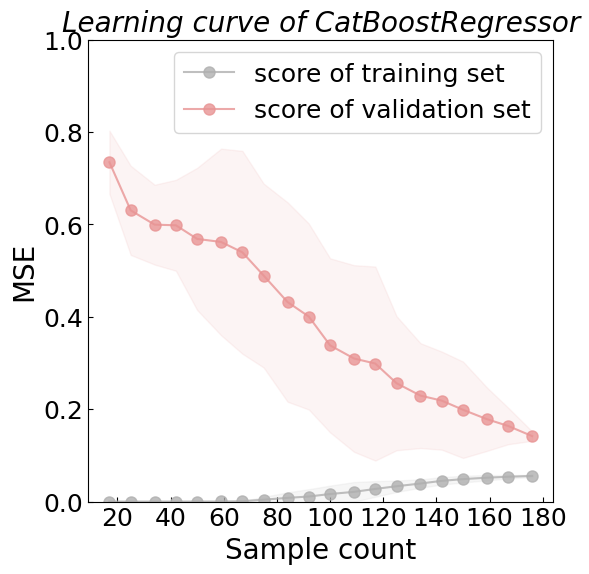

In [30]:
lc_catr = learning_curve_plot(best_catreg, model_name_s = type(best_catreg).__name__)
lc_catr

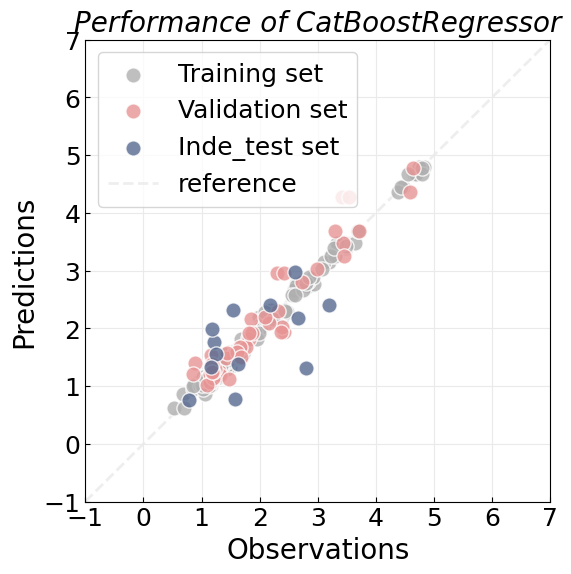

,Evaluation criterion,Training Data,validtation Data,independent test Data
0,MSE,0.006472,0.085497,0.429078
1,RMSE,0.080451,0.292398,0.655040
2,MAE,0.060469,0.200921,0.538922
3,R2_Score,0.993128,0.908651,0.209690


In [31]:
best_catreg_metrics,y_test_pred = model_builder(best_catreg)
best_catreg_metrics

In [32]:
validation_mse_list = []
validation_rmse_list = []
validation_mae_list =[]
for i in range(20):
    
    X_train_n, X_validation_n, y_train_n, y_validation_n = train_test_split(X_combined_norm, y_combined.values.ravel(), test_size=0.2)
    best_catreg.fit(X_train_n,y_train_n)
    
    y_validation_pred_n = best_catreg.predict(X_validation_n)
    validation_rmse = RMSE(y_validation_pred_n,y_validation_n)
    validation_mse = validation_rmse ** 2
    validation_mae = MAE(y_validation_pred_n,y_validation_n)
    
    validation_mse_list.append(validation_mse)
    validation_rmse_list.append(validation_rmse)
    validation_mae_list.append(validation_mae)

print("Average validation_mse after 20 interations:",sum(validation_mse_list)/len(validation_mse_list))
print("Average validation_rmse after 20 interations:",sum(validation_rmse_list)/len(validation_rmse_list))
print("Average validation_mae after 20 interations:",sum(validation_mae_list)/len(validation_mae_list))

Average validation_mse after 20 interations: 0.15608746972011228
Average validation_rmse after 20 interations: 0.37373107231332103
Average validation_mae after 20 interations: 0.23248929378919603


#### 4.Modle explaination for CATBOOST

In [33]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(best_catreg)
shap_values = explainer(X_combined_norm)

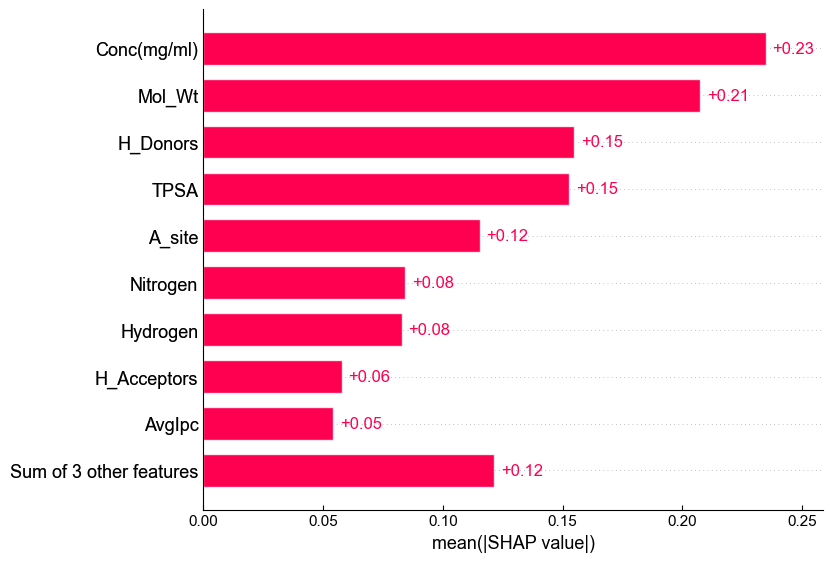

In [34]:

plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 24
plt.rcParams["axes.labelsize"] = 24
plt.rcParams["xtick.labelsize"] = 24
plt.rcParams["ytick.labelsize"] = 24


#Feature importance 
shap.plots.bar(shap_values,show = False)

plt.savefig(
    "output_figures/clustering.png",
    format='png',
    dpi=600,
    bbox_inches='tight'
)



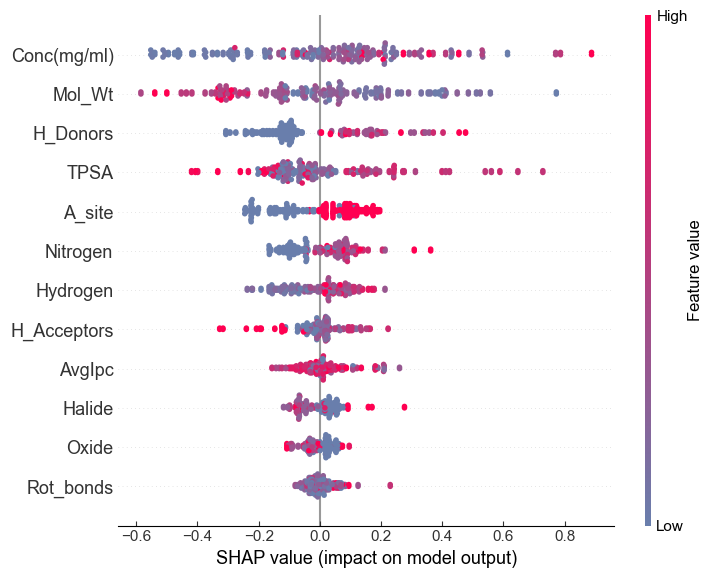

In [35]:
#Summarize the effects of all the features
from matplotlib.colors import LinearSegmentedColormap

colors = [ "#697EAC","#FF0051"] 
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

shap.summary_plot(
    shap_values,
    X_combined_norm,
    cmap=custom_cmap,
    plot_type="dot",  
    show=False
)
plt.tight_layout()
plt.savefig("output_figures/shap_summaryplot_comb.png", format='png', dpi= 600, bbox_inches='tight')  

<Figure size 400x300 with 0 Axes>

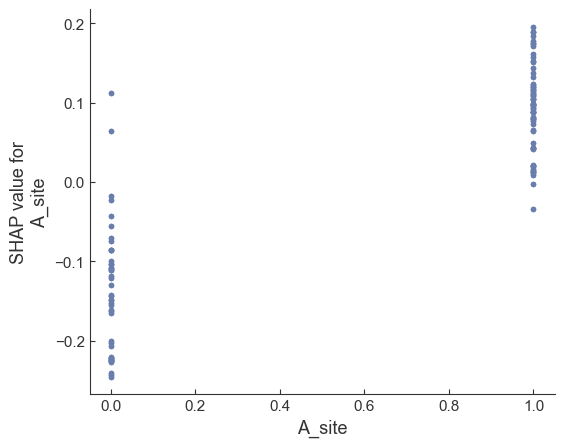

<Figure size 400x300 with 0 Axes>

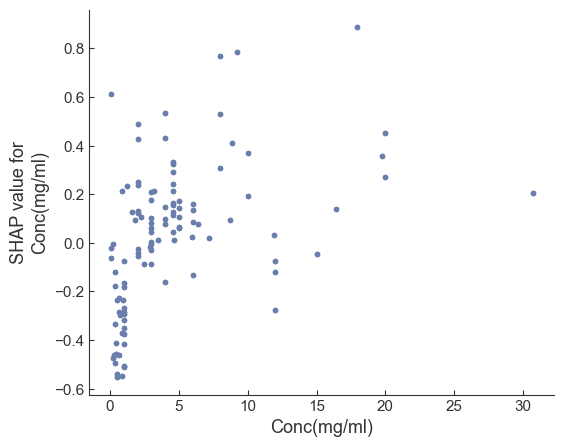

<Figure size 400x300 with 0 Axes>

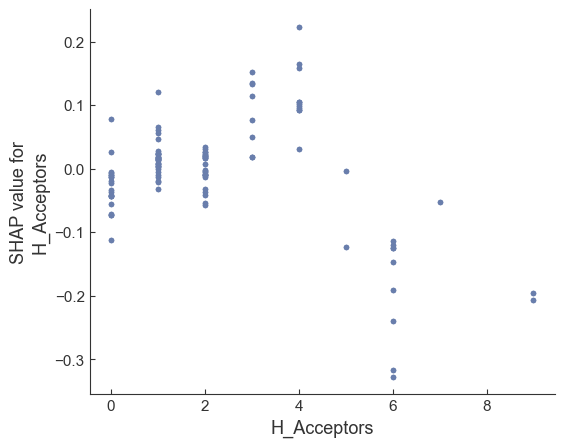

<Figure size 400x300 with 0 Axes>

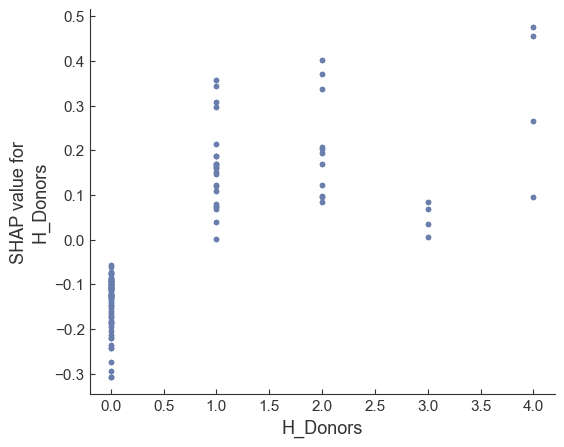

<Figure size 400x300 with 0 Axes>

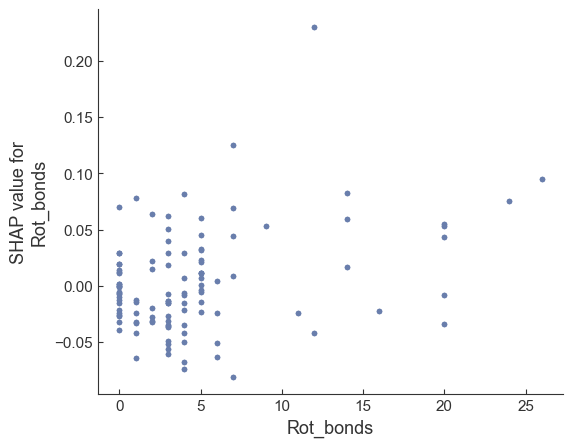

<Figure size 400x300 with 0 Axes>

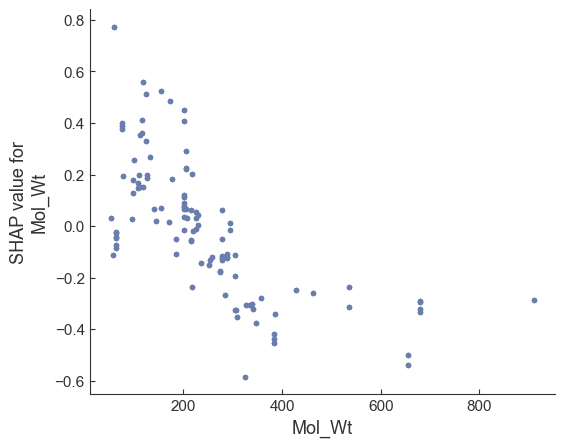

<Figure size 400x300 with 0 Axes>

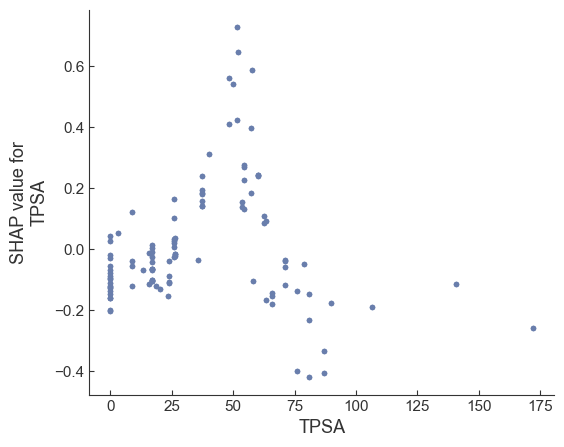

<Figure size 400x300 with 0 Axes>

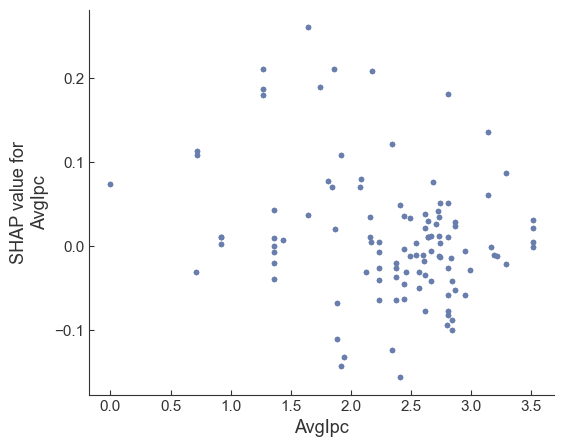

<Figure size 400x300 with 0 Axes>

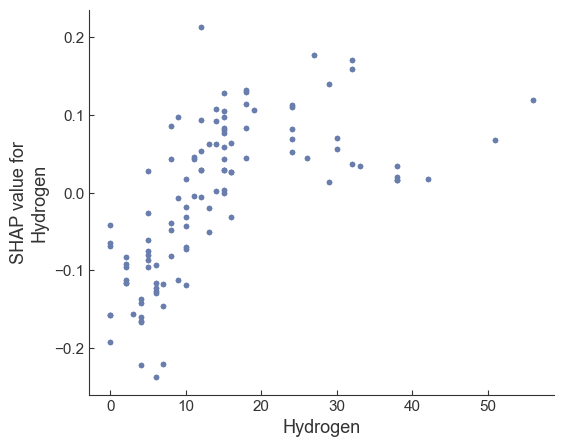

<Figure size 400x300 with 0 Axes>

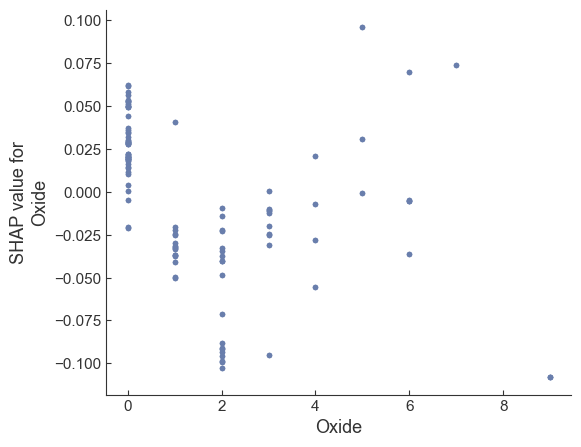

<Figure size 400x300 with 0 Axes>

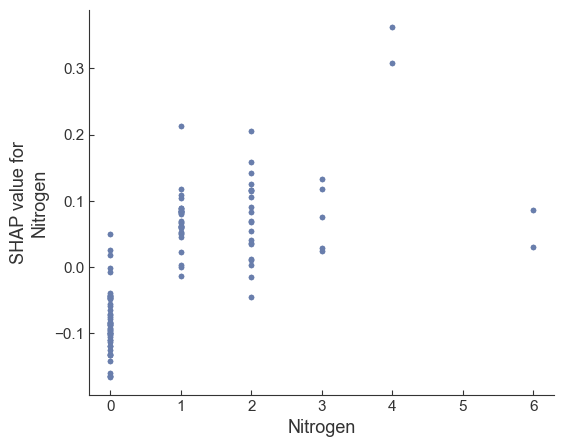

<Figure size 400x300 with 0 Axes>

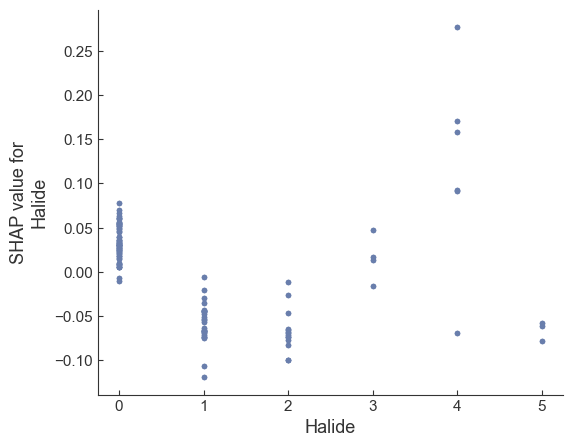

In [36]:
color = [ "#697EAC"] 
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", color)
plt.rcParams["font.family"] = "Arial"         
plt.rcParams["font.size"] = 24                
plt.rcParams["axes.labelsize"] = 24            
plt.rcParams["xtick.labelsize"] = 24          
plt.rcParams["ytick.labelsize"] = 24  
i = 0
for name in X_combined.columns:
  i= i+1
  plt.figure(figsize=(4,3))
  shap.dependence_plot(name,shap_values.values,X_combined,feature_names= X_combined_norm.columns, color="#697EAC",interaction_index=None,show=False)
  plt.savefig(f"output_figures/{i}.png", format='png',dpi = 600,bbox_inches='tight')  
  plt.show()

#### 5.Prediction for  passivators from Pubchem database

In [37]:

passivators_for_prediction = pd.read_csv("data/newpassivator_with_features.csv")
print("shape:",passivators_for_prediction.shape)
passivators_for_prediction.head(5)

shape: (700, 16)


,CID,IUPACName,MolecularFormula,IsomericSMILES,A_site,Conc(mg/ml),H_Acceptors,H_Donors,Rot_bonds,Mol_Wt,TPSA,AvgIpc,Hydrogen,Oxide,Nitrogen,Halide
0,7812.0,4-chloroaniline,C6H6ClN,C1=CC(=CC=C1N)Cl,0.0,1.0,1,1,1,127.574,26.02,2.112066,6,0,1,1
1,7423.0,3-nitroaniline,C6H6N2O2,C1=CC(=CC(=C1)[N+](=O)[O-])N,0.0,1.0,3,1,2,138.126,69.16,2.131108,6,2,2,0
2,9731.0,4-fluoroaniline,C6H6FN,C1=CC(=CC=C1N)F,0.0,1.0,1,1,1,111.119,26.02,2.112066,6,0,1,1
3,7447.0,2-methoxy-5-nitroaniline,C7H8N2O3,COC1=C(C=C(C=C1)[N+](=O)[O-])N,0.0,1.0,4,1,4,168.152,78.39,2.222235,8,3,2,0
4,7441.0,2-methyl-4-nitroaniline,C7H8N2O2,CC1=C(C=CC(=C1)[N+](=O)[O-])N,0.0,1.0,3,1,3,152.153,69.16,2.196466,8,2,2,0


In [38]:
X_prediction = passivators_for_prediction.iloc[:,4:]
X_prediction.head(20)

,A_site,Conc(mg/ml),H_Acceptors,H_Donors,Rot_bonds,Mol_Wt,TPSA,AvgIpc,Hydrogen,Oxide,Nitrogen,Halide
0,0.0,1.0,1,1,1,127.574,26.02,2.112066,6,0,1,1
1,0.0,1.0,3,1,2,138.126,69.16,2.131108,6,2,2,0
2,0.0,1.0,1,1,1,111.119,26.02,2.112066,6,0,1,1
3,0.0,1.0,4,1,4,168.152,78.39,2.222235,8,3,2,0
4,0.0,1.0,3,1,3,152.153,69.16,2.196466,8,2,2,0
5,0.0,1.0,3,1,3,171.221,60.16,2.242309,9,2,1,0
6,0.0,1.0,4,1,6,196.206,78.39,2.416056,12,3,2,0
7,0.0,1.0,3,1,2,178.235,38.49,2.459172,14,1,2,0
8,0.0,1.0,3,1,2,172.571,69.16,2.183714,5,2,2,1
9,0.0,1.0,3,1,2,225.191,60.16,2.242309,6,2,1,3


In [39]:
X_prediction_norm = X_scaler.fit_transform(X_prediction)
X_prediction_norm = pd.DataFrame(X_prediction_norm,columns=X_prediction.columns)
X_prediction_norm.head(20)

,A_site,Conc(mg/ml),H_Acceptors,H_Donors,Rot_bonds,Mol_Wt,TPSA,AvgIpc,Hydrogen,Oxide,Nitrogen,Halide
0,0.0,0.0,0.000000,0.25,0.052632,0.164373,0.071617,0.317127,0.147059,0.000,0.25,0.25
1,0.0,0.0,0.285714,0.25,0.105263,0.190062,0.416820,0.329928,0.147059,0.250,0.50,0.00
2,0.0,0.0,0.000000,0.25,0.052632,0.124313,0.071617,0.317127,0.147059,0.000,0.25,0.25
3,0.0,0.0,0.428571,0.25,0.210526,0.263160,0.490678,0.391190,0.205882,0.375,0.50,0.00
4,0.0,0.0,0.285714,0.25,0.157895,0.224211,0.416820,0.373866,0.205882,0.250,0.50,0.00
5,0.0,0.0,0.285714,0.25,0.157895,0.270632,0.344803,0.404685,0.235294,0.250,0.25,0.00
6,0.0,0.0,0.428571,0.25,0.315789,0.331458,0.490678,0.521488,0.323529,0.375,0.50,0.00
7,0.0,0.0,0.285714,0.25,0.105263,0.287707,0.171401,0.550474,0.382353,0.125,0.50,0.00
8,0.0,0.0,0.285714,0.25,0.105263,0.273918,0.416820,0.365293,0.117647,0.250,0.50,0.25
9,0.0,0.0,0.285714,0.25,0.105263,0.402022,0.344803,0.404685,0.147059,0.250,0.25,0.75


In [40]:
X_prediction = passivators_for_prediction.iloc[:,4:]
X_prediction.head()

,A_site,Conc(mg/ml),H_Acceptors,H_Donors,Rot_bonds,Mol_Wt,TPSA,AvgIpc,Hydrogen,Oxide,Nitrogen,Halide
0,0.0,1.0,1,1,1,127.574,26.02,2.112066,6,0,1,1
1,0.0,1.0,3,1,2,138.126,69.16,2.131108,6,2,2,0
2,0.0,1.0,1,1,1,111.119,26.02,2.112066,6,0,1,1
3,0.0,1.0,4,1,4,168.152,78.39,2.222235,8,3,2,0
4,0.0,1.0,3,1,3,152.153,69.16,2.196466,8,2,2,0


In [41]:
y_prediction = best_catreg.predict(X_prediction_norm)


In [42]:
prediction_res = passivators_for_prediction.iloc[:,:6]
prediction_res["EQE prediciton enhancement ratio"] = y_prediction
prediction_res_sorted = prediction_res.sort_values(by="CID",ascending=True)
#CsPbBr3
prediction_res_1_sorted = prediction_res_sorted[prediction_res_sorted['A_site'] == 1]
print(prediction_res_1_sorted.shape)
prediction_res_1_sorted.head(20)

(350, 7)


,CID,IUPACName,MolecularFormula,IsomericSMILES,A_site,Conc(mg/ml),EQE prediciton enhancement ratio
513,240.0,benzaldehyde,C7H6O,C1=CC=C(C=C1)C=O,1.0,4.0,1.820800
583,240.0,benzaldehyde,C7H6O,C1=CC=C(C=C1)C=O,1.0,6.0,2.127199
443,240.0,benzaldehyde,C7H6O,C1=CC=C(C=C1)C=O,1.0,2.0,1.698863
373,240.0,benzaldehyde,C7H6O,C1=CC=C(C=C1)C=O,1.0,1.0,1.959163
653,240.0,benzaldehyde,C7H6O,C1=CC=C(C=C1)C=O,1.0,8.0,2.127199
410,255.0,bis(4-nitrophenyl) hydrogen phosphate,C12H9N2O8P,C1=CC(=CC=C1[N+](=O)[O-])OP(=O)(O)OC2=CC=C(C=C...,1.0,1.0,1.908454
620,255.0,bis(4-nitrophenyl) hydrogen phosphate,C12H9N2O8P,C1=CC(=CC=C1[N+](=O)[O-])OP(=O)(O)OC2=CC=C(C=C...,1.0,6.0,1.768127
690,255.0,bis(4-nitrophenyl) hydrogen phosphate,C12H9N2O8P,C1=CC(=CC=C1[N+](=O)[O-])OP(=O)(O)OC2=CC=C(C=C...,1.0,8.0,1.768127
550,255.0,bis(4-nitrophenyl) hydrogen phosphate,C12H9N2O8P,C1=CC(=CC=C1[N+](=O)[O-])OP(=O)(O)OC2=CC=C(C=C...,1.0,4.0,1.649478
480,255.0,bis(4-nitrophenyl) hydrogen phosphate,C12H9N2O8P,C1=CC(=CC=C1[N+](=O)[O-])OP(=O)(O)OC2=CC=C(C=C...,1.0,2.0,1.414662


In [43]:
prediction_res_1_average = prediction_res_1_sorted.groupby(['CID','IUPACName','MolecularFormula','IsomericSMILES','A_site'],as_index=False).agg({'EQE prediciton enhancement ratio':'mean'})
prediction_res_1_average = prediction_res_1_average.rename(columns={'EQE prediciton enhancement ratio':'average pred EQE enhancement ratio'})
prediction_res_1_average.head(20)

,CID,IUPACName,MolecularFormula,IsomericSMILES,A_site,average pred EQE enhancement ratio
0,240.0,benzaldehyde,C7H6O,C1=CC=C(C=C1)C=O,1.0,1.946645
1,255.0,bis(4-nitrophenyl) hydrogen phosphate,C12H9N2O8P,C1=CC(=CC=C1[N+](=O)[O-])OP(=O)(O)OC2=CC=C(C=C...,1.0,1.701769
2,370.0,"3,4,5-trihydroxybenzoic acid",C7H6O5,C1=C(C=C(C(=C1O)O)O)C(=O)O,1.0,2.303714
3,379.0,octanoic acid,C8H16O2,CCCCCCCC(=O)O,1.0,2.399577
4,612.0,2-hydroxypropanoic acid,C3H6O3,CC(C(=O)O)O,1.0,3.752916
5,654.0,diethyl hydrogen phosphate,C4H11O4P,CCOP(=O)(O)OCC,1.0,2.546216
6,668.0,(3-hydroxy-2-oxopropyl) dihydrogen phosphate,C3H7O6P,C(C(=O)COP(=O)(O)O)O,1.0,2.076781
7,936.0,pyridine-3-carboxamide,C6H6N2O,C1=CC(=CN=C1)C(=O)N,1.0,3.423775
8,967.0,"2,4-dioxo-1H-pyrimidine-6-carboxylic acid",C5H4N2O4,C1=C(NC(=O)NC1=O)C(=O)O,1.0,2.066821
9,978.0,4-aminobenzoic acid,C7H7NO2,C1=CC(=CC=C1C(=O)O)N,1.0,2.611709


In [44]:
#top 10
prediction_res_1_average.sort_values(by='average pred EQE enhancement ratio',ascending=False).head(10)

,CID,IUPACName,MolecularFormula,IsomericSMILES,A_site,average pred EQE enhancement ratio
4,612.0,2-hydroxypropanoic acid,C3H6O3,CC(C(=O)O)O,1.0,3.752916
7,936.0,pyridine-3-carboxamide,C6H6N2O,C1=CC(=CN=C1)C(=O)N,1.0,3.423775
43,13134.0,dimethyl hydrogen phosphate,C2H7O4P,COP(=O)(O)OC,1.0,3.311908
14,1176.0,urea,CH4N2O,C(=O)(N)N,1.0,2.920401
40,12307.0,propyl nitrate,C3H7NO3,CCCO[N+](=O)[O-],1.0,2.854169
37,9731.0,4-fluoroaniline,C6H6FN,C1=CC(=CC=C1N)F,1.0,2.771568
16,1678.0,3-nitropropanoic acid,C3H5NO4,C(C[N+](=O)[O-])C(=O)O,1.0,2.741399
17,3442.0,5-butylpyridine-2-carboxylic acid,C10H13NO2,CCCCC1=CN=C(C=C1)C(=O)O,1.0,2.736297
31,7812.0,4-chloroaniline,C6H6ClN,C1=CC(=CC=C1N)Cl,1.0,2.684386
34,8431.0,ethyl piperazine-1-carboxylate,C7H14N2O2,CCOC(=O)N1CCNCC1,1.0,2.669454


In [45]:
#last 10
prediction_res_1_average.sort_values(by='average pred EQE enhancement ratio',ascending=True).head(10)

,CID,IUPACName,MolecularFormula,IsomericSMILES,A_site,average pred EQE enhancement ratio
33,8330.0,"1,2,4,5-tetrachloro-3-nitrobenzene",C6HCl4NO2,C1=C(C(=C(C(=C1Cl)Cl)[N+](=O)[O-])Cl)Cl,1.0,1.579576
36,9395.0,diethyl (4-nitrophenyl) phosphate,C10H14NO6P,CCOP(=O)(OCC)OC1=CC=C(C=C1)[N+](=O)[O-],1.0,1.698010
1,255.0,bis(4-nitrophenyl) hydrogen phosphate,C12H9N2O8P,C1=CC(=CC=C1[N+](=O)[O-])OP(=O)(O)OC2=CC=C(C=C...,1.0,1.701769
32,7873.0,diethoxyphosphoryl diethyl phosphate,C8H20O7P2,CCOP(=O)(OCC)OP(=O)(OCC)OCC,1.0,1.764019
66,4190003.0,benzenesulfinyl chloride,C6H5ClOS,C1=CC=C(C=C1)S(=O)Cl,1.0,1.768253
41,12495.0,1-iodo-4-nitrobenzene,C6H4INO2,C1=CC(=CC=C1[N+](=O)[O-])I,1.0,1.774494
22,7369.0,benzenesulfonyl chloride,C6H5ClO2S,C1=CC=C(C=C1)S(=O)(=O)Cl,1.0,1.787469
69,12669616.0,4-fluorobenzenesulfinyl chloride,C6H4ClFOS,C1=CC(=CC=C1F)S(=O)Cl,1.0,1.789658
65,222556.0,"2,4,6-triiodoaniline",C6H4I3N,C1=C(C=C(C(=C1I)N)I)I,1.0,1.790882
58,75498.0,"5-(1,3-dioxo-2-benzofuran-5-carbonyl)-2-benzof...",C17H6O7,C1=CC2=C(C=C1C(=O)C3=CC4=C(C=C3)C(=O)OC4=O)C(=...,1.0,1.881145


In [46]:
#LA  612 no.1
LA_pred = prediction_res[(prediction_res['CID'] == 612) & (prediction_res['A_site'] == 1)]
LA_pred

,CID,IUPACName,MolecularFormula,IsomericSMILES,A_site,Conc(mg/ml),EQE prediciton enhancement ratio
363,612.0,2-hydroxypropanoic acid,C3H6O3,CC(C(=O)O)O,1.0,1.0,3.193122
433,612.0,2-hydroxypropanoic acid,C3H6O3,CC(C(=O)O)O,1.0,2.0,3.337670
503,612.0,2-hydroxypropanoic acid,C3H6O3,CC(C(=O)O)O,1.0,4.0,3.808153
573,612.0,2-hydroxypropanoic acid,C3H6O3,CC(C(=O)O)O,1.0,6.0,4.212819
643,612.0,2-hydroxypropanoic acid,C3H6O3,CC(C(=O)O)O,1.0,8.0,4.212819


In [47]:
#LA  mean
LA_pred['EQE prediciton enhancement ratio'].mean()

3.752916328639747

In [48]:
#P3C  936 no.2
P3C_pred = prediction_res[(prediction_res['CID'] == 936) & (prediction_res['A_site'] == 1)]
P3C_pred

,CID,IUPACName,MolecularFormula,IsomericSMILES,A_site,Conc(mg/ml),EQE prediciton enhancement ratio
372,936.0,pyridine-3-carboxamide,C6H6N2O,C1=CC(=CN=C1)C(=O)N,1.0,1.0,2.875758
442,936.0,pyridine-3-carboxamide,C6H6N2O,C1=CC(=CN=C1)C(=O)N,1.0,2.0,3.106744
512,936.0,pyridine-3-carboxamide,C6H6N2O,C1=CC(=CN=C1)C(=O)N,1.0,4.0,3.515876
582,936.0,pyridine-3-carboxamide,C6H6N2O,C1=CC(=CN=C1)C(=O)N,1.0,6.0,3.810249
652,936.0,pyridine-3-carboxamide,C6H6N2O,C1=CC(=CN=C1)C(=O)N,1.0,8.0,3.810249


In [49]:
#P3C mean
P3C_pred['EQE prediciton enhancement ratio'].mean()

3.423775344427509

In [50]:
#DP 13134 no.3
DP_pred = prediction_res[(prediction_res['CID'] == 13134) & (prediction_res['A_site'] == 1)]
DP_pred


,CID,IUPACName,MolecularFormula,IsomericSMILES,A_site,Conc(mg/ml),EQE prediciton enhancement ratio
403,13134.0,dimethyl hydrogen phosphate,C2H7O4P,COP(=O)(O)OC,1.0,1.0,3.178453
473,13134.0,dimethyl hydrogen phosphate,C2H7O4P,COP(=O)(O)OC,1.0,2.0,2.804449
543,13134.0,dimethyl hydrogen phosphate,C2H7O4P,COP(=O)(O)OC,1.0,4.0,3.237823
613,13134.0,dimethyl hydrogen phosphate,C2H7O4P,COP(=O)(O)OC,1.0,6.0,3.669407
683,13134.0,dimethyl hydrogen phosphate,C2H7O4P,COP(=O)(O)OC,1.0,8.0,3.669407


In [51]:
#DP mean 
DP_pred['EQE prediciton enhancement ratio'].mean()

3.3119079150123234

In [52]:
#BC test suzhou
BC_pred = prediction_res[(prediction_res['CID'] == 7369) & (prediction_res['A_site'] == 1)]
BC_pred

,CID,IUPACName,MolecularFormula,IsomericSMILES,A_site,Conc(mg/ml),EQE prediciton enhancement ratio
416,7369.0,benzenesulfonyl chloride,C6H5ClO2S,C1=CC=C(C=C1)S(=O)(=O)Cl,1.0,1.0,2.047037
486,7369.0,benzenesulfonyl chloride,C6H5ClO2S,C1=CC=C(C=C1)S(=O)(=O)Cl,1.0,2.0,1.500180
556,7369.0,benzenesulfonyl chloride,C6H5ClO2S,C1=CC=C(C=C1)S(=O)(=O)Cl,1.0,4.0,1.601710
626,7369.0,benzenesulfonyl chloride,C6H5ClO2S,C1=CC=C(C=C1)S(=O)(=O)Cl,1.0,6.0,1.894209
696,7369.0,benzenesulfonyl chloride,C6H5ClO2S,C1=CC=C(C=C1)S(=O)(=O)Cl,1.0,8.0,1.894209


In [53]:
#BC mean 7369
BC_pred['EQE prediciton enhancement ratio'].mean()

1.787469211131728

In [54]:
#last 8330
TE_pred = prediction_res[(prediction_res['CID'] == 8330) & (prediction_res['A_site'] == 1)]
TE_pred

,CID,IUPACName,MolecularFormula,IsomericSMILES,A_site,Conc(mg/ml),EQE prediciton enhancement ratio
397,8330.0,"1,2,4,5-tetrachloro-3-nitrobenzene",C6HCl4NO2,C1=C(C(=C(C(=C1Cl)Cl)[N+](=O)[O-])Cl)Cl,1.0,1.0,1.767503
467,8330.0,"1,2,4,5-tetrachloro-3-nitrobenzene",C6HCl4NO2,C1=C(C(=C(C(=C1Cl)Cl)[N+](=O)[O-])Cl)Cl,1.0,2.0,1.508444
537,8330.0,"1,2,4,5-tetrachloro-3-nitrobenzene",C6HCl4NO2,C1=C(C(=C(C(=C1Cl)Cl)[N+](=O)[O-])Cl)Cl,1.0,4.0,1.449202
607,8330.0,"1,2,4,5-tetrachloro-3-nitrobenzene",C6HCl4NO2,C1=C(C(=C(C(=C1Cl)Cl)[N+](=O)[O-])Cl)Cl,1.0,6.0,1.586366
677,8330.0,"1,2,4,5-tetrachloro-3-nitrobenzene",C6HCl4NO2,C1=C(C(=C(C(=C1Cl)Cl)[N+](=O)[O-])Cl)Cl,1.0,8.0,1.586366


In [55]:
TE_pred['EQE prediciton enhancement ratio'].mean()

1.5795759919587147